## Importing libraries

In [58]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.decomposition import TruncatedSVD
import torch
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset

## Loading Datasets

In [75]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
sample_submission = pd.read_csv('sample_submission.csv')

## EDA 

In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [35]:
train_data.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [36]:
train_data.describe()

id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000

In [39]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [37]:
test_data.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [40]:
test_data.describe()

id
count   3263.000000
mean    5427.152927
std     3146.427221
min        0.000000
25%     2683.000000
50%     5500.000000
75%     8176.000000
max    10875.000000

In [45]:
import plotly_express as px
import matplotlib.pyplot as plt 

fig=px.pie(train_data,names="target",title="Target Disributions")
fig.update_layout(title={"x":0.5,"y":0.8,"xanchor":"center","yanchor":"top"})
fig.show()

In [46]:
number=len(train_data['location'].unique())
print("Tweets come from {} differents locations ".format(number))

Tweets come from 3342 differents locations 


#### TOP 20 locations

In [47]:
top_30=pd.DataFrame(train_data['location'].value_counts()[:30]).reset_index(drop=False)

In [50]:
fig=px.bar(top_30,x="count",y='location',orientation='v',color="location",title=\
          "Top 30 most used Countries ")
fig.update_layout(title={"x":0.475,"y":0.9,"xanchor":"center","yanchor":"top"})
fig.show()

#### Top 20 KeyWords

In [52]:
df=train_data[train_data['target']==1]
top_20=pd.DataFrame(df['keyword'].value_counts()[:20]).reset_index(drop=False)
top_20.columns=['keywords','location']

In [53]:
fig=px.bar(top_20,x="keywords",y="location",color='location',title=\
          "Top 20 most used keyword for disaster tweets")
fig.update_layout(title={"x":0.475,"y":0.9,"xanchor":"center","yanchor":\
                        "top"})
fig.show()

### TA

In [54]:
tx=" ".join(df['text'].values.tolist())

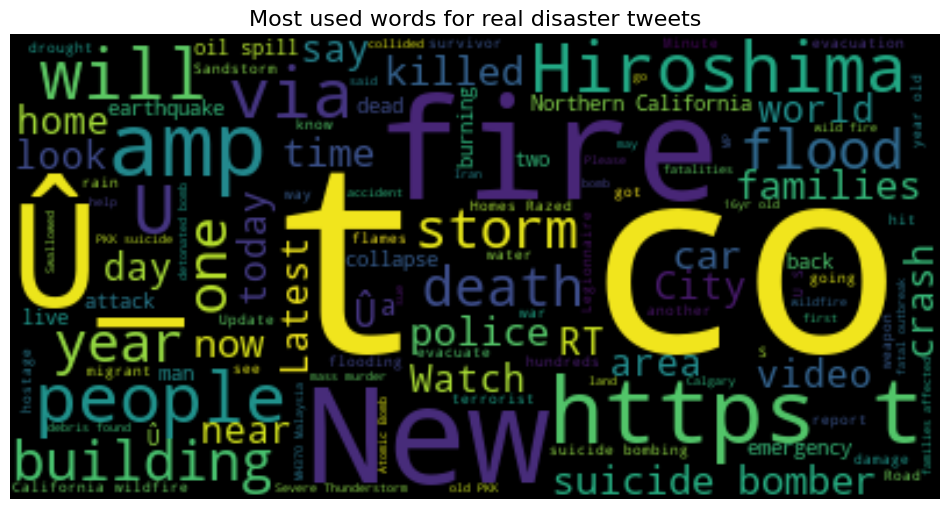

In [56]:
from wordcloud import WordCloud
fig,ax1=plt.subplots(1,1,figsize=(12,16))
wordcl=WordCloud().generate(tx)
plt.imshow(wordcl,interpolation="bilinear")
plt.axis("off")
plt.title("Most used words for real disaster tweets",fontsize=16)
plt.show()

### Preprocessing function for the text data

In [18]:
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = text.strip()
    return text

# Stemming and Lemmatization
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [21]:
import nltk
nltk.download('wordnet')
def preprocess(text):
    text = preprocess_text(text)
    text = " ".join([lemmatizer.lemmatize(stemmer.stem(word)) for word in text.split()])
    return text

train_data['extended_cleaned_text'] = train_data['text'].apply(preprocess)
test_data['extended_cleaned_text'] = test_data['text'].apply(preprocess)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ilgiznurlanov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Vectorization

In [24]:
word_vectorizer = TfidfVectorizer(max_features=7000, stop_words='english', ngram_range=(1, 3),analyzer='word')
char_vectorizer = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1, 5), analyzer='char')
vectorizer = FeatureUnion([
    ('word_vectorizer', word_vectorizer),
    ('char_vectorizer', char_vectorizer)
])
vectorizer.fit(pd.concat([train_data['extended_cleaned_text'], test_data['extended_cleaned_text']]))

FeatureUnion(transformer_list=[('word_vectorizer',
                                TfidfVectorizer(max_features=7000,
                                                ngram_range=(1, 3),
                                                stop_words='english')),
                               ('char_vectorizer',
                                TfidfVectorizer(analyzer='char',
                                                max_features=3000,
                                                ngram_range=(1, 5),
                                                stop_words='english'))])

### Splitting data for evaluation: Train, Validation, and Test

In [25]:
X = train_data['extended_cleaned_text']
y = train_data['target']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_vec = vectorizer.transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(test_data['extended_cleaned_text'])

### Reducing Dimensionality

In [26]:
svd = TruncatedSVD(n_components=5000, random_state=42)
X_train_vec = svd.fit_transform(X_train_vec)
X_val_vec = svd.transform(X_val_vec)
X_test_vec = svd.transform(X_test_vec)

### Logistic Regression and Random Forest classifiers


In [27]:
lr = LogisticRegression(max_iter=5000, random_state=42, solver='lbfgs')
rf = RandomForestClassifier(random_state=42)

### Hyperparameters

In [28]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

### GridSearchCV setup

In [29]:
grid_clf_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_clf_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

### Fitting and evaluation of Logistic Regression

In [30]:
grid_clf_lr.fit(X_train_vec, y_train)
val_predictions_lr = grid_clf_lr.predict(X_val_vec)
print("Logistic Regression Results:")
print("Best Parameters:", grid_clf_lr.best_params_)
print(classification_report(y_val, val_predictions_lr))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Logistic Regression Results:
Best Parameters: {'C': 1}
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       683
           1       0.83      0.73      0.77       459

    accuracy                           0.83      1142
   macro avg       0.83      0.81      0.82      1142
weighted avg       0.83      0.83      0.83      1142



### Fitting and evaluation of Random Forest

In [31]:
grid_clf_rf.fit(X_train_vec, y_train)
val_predictions_rf = grid_clf_rf.predict(X_val_vec)
print("\nRandom Forest Results:")
print("Best Parameters:", grid_clf_rf.best_params_)
print(classification_report(y_val, val_predictions_rf))

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Random Forest Results:
Best Parameters: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.70      0.51      0.59       683
           1       0.48      0.67      0.56       459

    accuracy                           0.57      1142
   macro avg       0.59      0.59      0.57      1142
weighted avg       0.61      0.57      0.57      1142



### Prediction and Submission

In [57]:
best_model = grid_clf_lr if grid_clf_lr.best_score_ > grid_clf_rf.best_score_ else grid_clf_rf
test_predictions = best_model.predict(X_test_vec)
submission = pd.DataFrame({
    'id': test_data['id'],
    'target': test_predictions
})
submission.to_csv("submission_logistic_reg.csv", index=False)
print("\nSubmission saved to 'submission_logistic_reg.csv'")


Submission saved to 'submission_logistic_reg.csv'


# Roberta Model

### Splitting data into training and validation sets and Tokenisation

In [76]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    return TensorDataset(encodings.input_ids, encodings.attention_mask, torch.tensor(labels))

train_texts, validation_texts, train_labels, validation_labels = train_test_split(train_data['text'], train_data['target'], test_size=0.1)
train_dataset = tokenize(train_texts.tolist(), train_labels.tolist())
validation_dataset = tokenize(validation_texts.tolist(), validation_labels.tolist())

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16)
validation_loader = DataLoader(validation_dataset, batch_size=16)

### Tuning and the training

In [77]:
from sklearn.metrics import accuracy_score

model = RobertaForSequenceClassification.from_pretrained('roberta-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

num_epochs = 3

def print_progress_bar(iteration, total, prefix='', suffix='', length=50, fill='█'):
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end='\r')
    if iteration == total:
        print()

for epoch in range(num_epochs):
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = len(train_loader)
    print(f"Starting Epoch {epoch + 1}/{num_epochs}")

    for idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()  # Accumulate batch loss
        
        # Calculate accuracy for the batch
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        batch_accuracy = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        total_accuracy += batch_accuracy

        loss.backward()
        optimizer.step()
        
        # Display progress bar
        print_progress_bar(idx + 1, num_batches, prefix=f'Epoch {epoch+1}', suffix=f'Loss: {loss.item():.4f}, Acc: {batch_accuracy:.4f}', length=50)

    # Print average loss and accuracy for the epoch
    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches
    print(f"\nEpoch {epoch + 1} Summary - Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f}\n")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Epoch 1/3
Epoch 1 |██████████████████████████████████████████████████| 100.0% Loss: 0.1075, Acc: 1.0000

Epoch 1 Summary - Average Loss: 0.4240, Average Accuracy: 0.8115

Starting Epoch 2/3
Epoch 2 |██████████████████████████████████████████████████| 100.0% Loss: 0.1006, Acc: 1.0000

Epoch 2 Summary - Average Loss: 0.2947, Average Accuracy: 0.8853

Starting Epoch 3/3
Epoch 3 |██████████████████████████████████████████████████| 100.0% Loss: 0.2611, Acc: 1.0000

Epoch 3 Summary - Average Loss: 0.1879, Average Accuracy: 0.9314



### Evaluation

In [78]:
model.eval()

correct_predictions = 0
total_predictions = 0

for batch in validation_loader:
    input_ids, attention_mask, labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    correct_predictions += (predictions == labels).sum().item()
    total_predictions += labels.size(0)

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8215


### Prediction

In [79]:
test_texts = test_data['text'].tolist()
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_input_ids = test_encodings.input_ids.to(device)
test_attention_mask = test_encodings.attention_mask.to(device)

with torch.no_grad():
    logits = model(test_input_ids, attention_mask=test_attention_mask).logits

predictions = torch.argmax(logits, dim=1).cpu().numpy()

### Submission

In [80]:
sample_submission['target'] = predictions
sample_submission.to_csv('submission_roberta2.csv', index=False)